# NFQ basado en Ventanas de Experiencia
### <font color='5E5D5D'> Descripción </font>

<i><font color='C9614B'>En esta notebook se encuentra el entrenamiento del agente NFQ basado en ventanas de experiencia o rollout (Experimento 2). Tener en cuenta que la configuración que se presenta aquí, representa únicamente una de las evaluadas.</font></i><br>

***

## Configuración

### Librerías

In [1]:
# Librerías del sistema que son prerequsito: descomentar estas líneas únicamente si se necesita su instalaciòn
! pip install gym pyvirtualdisplay > /dev/null 2>&1
! apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1

# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms

# Gym
import gym
from gym.wrappers import Monitor

# Visualización
from IPython.display import HTML
from pyvirtualdisplay import Display
from IPython import display as ipythondisplay
from tqdm.notebook import tqdm
from PIL import Image

# Misceláneos
import matplotlib.pyplot as plt
import io
import glob
import base64
import math
import random
import numpy as np
from collections import namedtuple
import itertools

In [ ]:
# Display
display = Display(visible=0, size=(1400, 900))
display.start()

## Funciones Auxiliares

In [3]:
def wrap_env(env):
    env = Monitor(env, './video', force=True)
    return env

In [4]:
def show_video():
    mp4list = glob.glob('video/*.mp4')
    if len(mp4list) > 0:
        mp4 = mp4list[0]
        video = io.open(mp4, 'r+b').read()
        encoded = base64.b64encode(video)
        ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                    loop controls style="height: 400px;">
                    <source src="data:video/mp4;base64,{0}" type="video/mp4" />
                 </video>'''.format(encoded.decode('ascii'))))
    else: 
        print("Could not find video")

In [5]:
def results_normalizing(number_episodes, rewards, steps):
  average_range = 100
  episode_ticks = int(number_episodes / average_range)

  avg_rewards = np.array(rewards).reshape((episode_ticks, average_range))
  avg_rewards = np.mean(avg_rewards, axis=1)

  avg_steps = np.array(steps).reshape((episode_ticks, average_range))
  avg_steps = np.mean(avg_steps, axis=1)

  return avg_rewards, avg_steps, episode_ticks

In [6]:
def plot_results(number_episodes, rewards, steps):
  avg_rewards, avg_steps, episode_ticks = results_normalizing(number_episodes, rewards, steps)

  plt.plot(range(episode_ticks), avg_rewards)
  plt.title("Episode Accumulated Reward")
  plt.xlabel("Episode Number")
  plt.ylabel("Reward")
  plt.show()

  plt.plot(range(episode_ticks), avg_steps)
  plt.title("Steps needed per episode")
  plt.xlabel("Episode Number")
  plt.ylabel("Number Steps")
  plt.show()

## Rollout


Funciones para obtener muestras de un ambiente o un dataset de forma offline.

In [7]:
Transition = namedtuple('Transition',
                        ('state', 'action', 'reward', 'done', 'next_state'))

class Rollout:

    def __init__(self):
        self.memory = []

    def add(self, state, action, reward, done, next_state):
        newElement= Transition(state, action, reward, done, next_state)
        self.memory.append(newElement)
 
    def sample(self, batch_size):
      return random.sample(self.memory, batch_size)
 
    def __len__(self):
      return len(self.memory)

    def get_rollout_from_env(self, env, process_state, device, policy_net=None):
      # Rollout
      rollout = []

      # Rewards
      episode_rewards = 0
      
      # Reinicio el ambiente
      state = process_state(env.reset()).to(device)
  
      done = False
      while not done:
        if policy_net is None:
          # Elijo una acción random
          action = np.random.choice(env.action_space.n)
        else:
          # Elijo una acción greedy en función de la aproximación actual
          action = torch.argmax(policy_net(state))
          action = action.item()

        # Ejecuto la acción sobre el ambiente
        next_state, reward, done, _ = env.step(action)
        next_state = process_state(next_state).to(device)
        
        # Agrego la tupla al rollout
        rollout.append((state, action, reward, done, next_state))

        # Incremento el reward
        episode_rewards += reward

        # Actualizo el estado
        state = next_state
      
      return rollout, episode_rewards

    def increment_rollout(self, rollout):
      for tr in rollout:
        # Almaceno en la memoria del rollout
        self.add(tr[0], tr[1], tr[2], tr[3], tr[4])

    def get_dataset_from_env(self, env, process_state, device, num_samples=1000):
      # Dataset
      dataset = []

      while len(dataset) < num_samples:
        # Reinicio el ambiente 
        state = process_state(env.reset()).to(device)
    
        done = False
        while not done:
          # Elijo una acción random
          action = np.random.choice(env.action_space.n)
          
          # Ejecuto la acción sobre el ambiente
          next_state, reward, done, _ = env.step(action)
          next_state = process_state(next_state).to(device)
          
          # Agrego la tupla al rollout
          dataset.append((state, action, reward, done, next_state))

          # Actualizo el estado
          state = next_state

      # Asigno el dataset al rollout
      self.increment_rollout(dataset)

## Red Neuronal (Modelo)

In [8]:
class NFQModel(nn.Module):
    
    def __init__(self, env_inputs, n_actions):
        super(NFQModel, self).__init__()
        # Hidden layer
        self.hidden = nn.Linear(in_features=env_inputs, out_features=200)
        # Output layer
        self.output = nn.Linear(in_features=200, out_features=n_actions)
        
    def forward(self, env_input):
        result = F.relu(self.hidden(env_input))
        output = self.output(result)

        return output

## Agente

In [13]:
class NFQAgent:
    def __init__(self, gym_env, model, obs_processing_func, batch_size, learning_rate, gamma):
        self.device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

        # Model
        self.policy_net = model.to(self.device)

        # Función de loss
        self.loss_function = nn.MSELoss().to(self.device)

        # Optimizador
        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=learning_rate)

        # Función de procesamiento de estados
        self.state_processing_function = obs_processing_func

        # Ambiente
        self.env = gym_env

        # Hiperparámetros
        self.batch_size = batch_size
        self.gamma = gamma


    def train_from_rollout(self, number_episodes, max_steps):
        episode_rewards = []                      # Trazabilidad de los rewards por episodio
        episode_steps = np.zeros(number_episodes) # Trazabilidad de steps por episodio
        total_steps = 0

        # Genero el rollout
        rollout = Rollout()

        for ep in tqdm(range(number_episodes), unit=' episodes'):

            # Genero una ventana de muestras
            roll, ep_rew = rollout.get_rollout_from_env(self.env, 
                                                        self.state_processing_function,
                                                        self.device,
                                                        self.policy_net)
            
            # Rewards acumulados
            episode_rewards.append(ep_rew)

            # Incremento
            rollout.increment_rollout(roll)

            for s in range(max_steps):

                # Actualizar el modelo
                self.update_weights_from_rollout(rollout)

            # Report on the traning rewards every 100 episodes
            if ep % 100 == 0:
                print(f"Episode {ep} - Avg. Reward over the last 100 episodes {np.mean(episode_rewards[-100:])}")

        print(f"Episode {ep + 1} - Avg. Reward over the last 100 episodes {np.mean(episode_rewards[-100:])}")

        return episode_rewards, episode_steps


    def update_weights_from_rollout(self, rollout):
        if len(rollout.memory) > self.batch_size:
            # Reseteo gradientes
            self.optimizer.zero_grad() 

            # Obtengo mini-batch
            batch = rollout.sample(self.batch_size)
            states, actions, rewards, dones, next_states = list(zip(*batch))

            # Envío los tensores al dispositivo
            states = (torch.stack(states)).to(self.device)
            actions = torch.tensor(actions).to(self.device)
            rewards = torch.tensor(rewards).to(self.device)
            dones = torch.tensor(dones).float().to(self.device)
            next_states = (torch.stack(next_states)).to(self.device)

            # Obtengo el Q value para el mini-batch de acuerdo con la policy_net
            q_actual = self.policy_net(states).gather(dim=1, index=actions.view(-1,1)).squeeze()
  
            # Obtengo max a' Q para los next_states del mini-batch
            max_q_next_state = self.policy_net(next_states)
            max_q_next_state = max_q_next_state.max(dim=1)[0]*(1 - dones)
            max_q_next_state = max_q_next_state.detach()

            # Calcular el target
            target = rewards + self.gamma * max_q_next_state
        
            # Computar el costo y actualizar los weights
            self.loss_function(q_actual, target).backward()
            self.optimizer.step()


    def record_test_episode(self, env):
        done = False
    
        # Obtengo estado inicial
        state = self.state_processing_function(env.reset()).to(self.device)

        while not done:
            env.render()

            # Selecciono una acción full-greedy
            action = self.select_action(state, 0, train=False)

            # Ejecuto la acción y proceso el resultado
            next_state, reward, done, _ = env.step(action)
            next_state = self.state_processing_function(next_state).to(self.device)

            if done:
                break      

            # Actualizo el estado
            state = next_state

        env.close()
        show_video()

In [10]:
def process_state(obs):
    return torch.from_numpy(obs).float()

## Tests para el Experimento 2

### Neural Fitted Q-Iteration con Ventanas de Experiencia

Entrenamiento de agente NFQ con rollouts, utilizando el ambiente ``MountainCar-v0``.

#### Mountain Car

In [11]:
# Global vars
GAMMA = 0.99
NUM_EPISODES = 3000
MAX_STEPS = 200

BATCH_SIZE = 32
LEARNING_RATE = 0.01

In [17]:
# Arrays para los resultados finales
rewards_nfq, steps_nfq = [], []

# Creo el ambiente
env = gym.make("MountainCar-v0")

# Seed
num_seed = 100
env.seed(num_seed)
random.seed(num_seed)
np.random.seed(num_seed)
torch.manual_seed(num_seed)
torch.backends.cudnn.deterministic = True

# Creo el modelo
modelo = NFQModel(2, env.action_space.n)

# Creo el agente
agent_nfq = NFQAgent(env, modelo, process_state, BATCH_SIZE, LEARNING_RATE, GAMMA)

# Entreno al agente
rewards, steps_per_episode = agent_nfq.train_from_rollout(NUM_EPISODES, MAX_STEPS)

# Resultados
rewards_nfq.append(rewards)
steps_nfq.append(steps_per_episode)

Episode 0 - Avg. Reward over the last 100 episodes -200.0
Episode 100 - Avg. Reward over the last 100 episodes -200.0
Episode 200 - Avg. Reward over the last 100 episodes -200.0
Episode 300 - Avg. Reward over the last 100 episodes -200.0
Episode 400 - Avg. Reward over the last 100 episodes -200.0
Episode 500 - Avg. Reward over the last 100 episodes -200.0
Episode 600 - Avg. Reward over the last 100 episodes -199.83
Episode 700 - Avg. Reward over the last 100 episodes -191.09
Episode 800 - Avg. Reward over the last 100 episodes -187.59
Episode 900 - Avg. Reward over the last 100 episodes -191.14
Episode 1000 - Avg. Reward over the last 100 episodes -185.58
Episode 1100 - Avg. Reward over the last 100 episodes -188.18
Episode 1200 - Avg. Reward over the last 100 episodes -185.86
Episode 1300 - Avg. Reward over the last 100 episodes -188.41
Episode 1400 - Avg. Reward over the last 100 episodes -182.28
Episode 1500 - Avg. Reward over the last 100 episodes -180.12
Episode 1600 - Avg. Reward

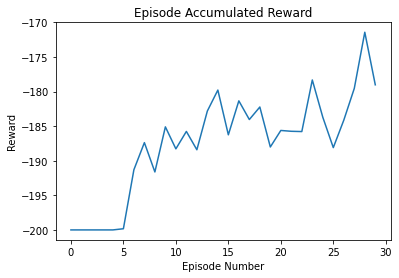

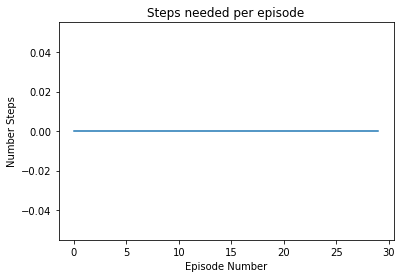

In [20]:
# Plot "suavizado"
plot_results(NUM_EPISODES, rewards_nfq, steps_nfq)

In [ ]:
# Video
wrapped_env = wrap_env(gym.make("MountainCar-v0"))

agent_nfq.record_test_episode(wrapped_env)